# 3. Check h5ad

In [9]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import matplotlib.pyplot as pl
import pathlib
import anndata as ad

import numpy as np
import pandas as pd
import lifelines
from lifelines import CoxPHFitter
from sklearn.model_selection import StratifiedKFold
from collections import OrderedDict


from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import neptune
import warnings
warnings.filterwarnings("ignore")
import shutil

#project_path = "/home/steinfej/projects/uk_biobank/"
#dataset_path = "data/datasets/"
project_name = "cvd_massive_excl_emb_ind"
shared_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/3_datasets_post"
from utils import setup, nanstr_to_nan, h5ad_ensure_dimensionality, h5ad_fillna

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

### Utils

In [ ]:
h5ad_fp = f"{shared_path}/{project_name}/prep/derived.filtered.transformed.h5ad"

In [11]:
h5ad_fp = f"{shared_path}/{project_name}/partition_0/valid/data.normalized.scores.h5ad"
data = ad.read_h5ad(h5ad_fp)

In [12]:
data

AnnData object with n_obs × n_vars = 39888 × 4167
    obs: 'eid'
    var: 'dtype', 'isTarget', 'based_on', 'aggr_fn', 'recoding', 'NewLevels'

In [4]:
#h5ad_fp = f"{shared_path}/{project_name}/prep/derived.filtered.transformed.h5ad"
h5ad_fp_train = f"{shared_path}/{project_name}/partition_0/train/data.normalized.h5ad"
h5ad_fp_valid = f"{shared_path}/{project_name}/partition_0/valid/data.normalized.h5ad"
h5ad_fp_test = f"{shared_path}/{project_name}/partition_0/test/data.normalized.h5ad"

In [5]:
data_train = ad.read_h5ad(h5ad_fp_train)
data_valid = ad.read_h5ad(h5ad_fp_valid)
data_test = ad.read_h5ad(h5ad_fp_test)

In [7]:
data_complete = data_train.concatenate(data_valid, data_test)

In [21]:
data_complete.write_h5ad(f"{shared_path}/cvd_massive_complete/complete.data.normalized.h5ad")

In [4]:
from pprint import pprint

In [5]:
measurements = ['body_mass_index_bmi',
  'weight',
  'pulse_wave_arterial_stiffness_index',
  'pulse_wave_reflection_index',
  'waist_circumference',
  'hip_circumference',
  'trunk_fat_percentage',
  'body_fat_percentage',
  'basal_metabolic_rate',
  'forced_vital_capacity_fvc_best_measure',
  'forced_expiratory_volume_in_1second_fev1_best_measure',
  'fev1_fvc_ratio_zscore',
  'peak_expiratory_flow_pef_f3064_0_2',
  'peak_expiratory_flow_pef_f3064_0_1',
  'peak_expiratory_flow_pef',
  'systolic_blood_pressure',
  'diastolic_blood_pressure',
  'pulse_rate']
labs =  ['basophill_count',
  'basophill_percentage',
  'eosinophill_count',
  'eosinophill_percentage',
  'haematocrit_percentage',
  'haemoglobin_concentration',
  'high_light_scatter_reticulocyte_count',
  'high_light_scatter_reticulocyte_percentage',
  'immature_reticulocyte_fraction',
  'lymphocyte_count',
  'lymphocyte_percentage',
  'mean_corpuscular_haemoglobin',
  'mean_corpuscular_haemoglobin_concentration',
  'mean_corpuscular_volume',
  'mean_platelet_thrombocyte_volume',
  'mean_reticulocyte_volume',
  'mean_sphered_cell_volume',
  'monocyte_count',
  'monocyte_percentage',
  'neutrophill_count',
  'neutrophill_percentage',
  'nucleated_red_blood_cell_count',
  'nucleated_red_blood_cell_percentage',
  'platelet_count',
  'platelet_crit',
  'platelet_distribution_width',
  'red_blood_cell_erythrocyte_count',
  'red_blood_cell_erythrocyte_distribution_width',
  'reticulocyte_count',
  'reticulocyte_percentage',
  'white_blood_cell_leukocyte_count',
  'alanine_aminotransferase',
  'albumin',
  'alkaline_phosphatase',
  'apolipoprotein_a',
  'apolipoprotein_b',
  'aspartate_aminotransferase',
  'creactive_protein',
  'calcium',
  'cholesterol',
  'creatinine',
  'cystatin_c',
  'direct_bilirubin',
  'gamma_glutamyltransferase',
  'glucose',
  'glycated_haemoglobin_hba1c',
  'hdl_cholesterol',
  'igf1',
  'ldl_direct',
  'lipoprotein_a',
  'oestradiol',
  'phosphate',
  'rheumatoid_factor',
  'shbg',
  'testosterone',
  'total_bilirubin',
  'total_protein',
  'triglycerides',
  'urate',
  'urea',
  'vitamin_d']

In [10]:
content = measurements + labs
content_original = [f"{e}_original" for e in content]
df_original = pd.DataFrame(data=data[:,content_original].X, columns = content_original)
df_scaled = pd.DataFrame(data=data[:, content].X, columns = content )

In [11]:
df_original

,body_mass_index_bmi_original,weight_original,pulse_wave_arterial_stiffness_index_original,pulse_wave_reflection_index_original,waist_circumference_original,hip_circumference_original,trunk_fat_percentage_original,body_fat_percentage_original,basal_metabolic_rate_original,forced_vital_capacity_fvc_best_measure_original,...,phosphate_original,rheumatoid_factor_original,shbg_original,testosterone_original,total_bilirubin_original,total_protein_original,triglycerides_original,urate_original,urea_original,vitamin_d_original
0,26.555700,63.799999,7.27700,80.0,85.000000,107.000000,37.500000,39.500000,5012.0,3.21,...,1.422,38.200001,70.110001,1.560000,7.41,71.970001,1.247,221.300003,5.48,70.699997
1,22.746500,70.699997,12.30770,45.0,87.800003,94.400002,33.400002,28.700001,6171.0,4.19,...,1.264,11.800000,55.310001,12.237000,8.07,78.449997,1.906,374.700012,5.28,35.900002
2,29.567900,95.800003,11.11110,78.0,98.000000,104.000000,27.600000,25.600000,8711.0,4.14,...,0.928,19.000000,31.629999,11.398000,8.65,69.699997,5.184,322.799988,6.67,63.599998
3,25.015600,60.099998,10.98160,52.0,86.000000,94.000000,34.200001,36.500000,4879.0,2.34,...,1.201,30.799999,6.750000,0.975000,6.29,72.419998,1.740,230.199997,8.16,60.400002
4,29.363199,88.900002,11.91490,50.0,106.000000,104.000000,28.700001,27.000000,7991.0,3.63,...,1.218,11.000000,27.209999,7.057000,9.52,78.919998,2.847,428.399994,4.50,26.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319103,21.936300,59.000000,12.19700,76.0,71.000000,88.000000,22.200001,19.299999,5786.0,4.50,...,1.136,11.500000,67.930000,20.207001,15.56,73.589996,0.965,262.600006,3.65,31.900000
319104,25.349300,72.400002,5.47619,39.0,86.000000,105.000000,37.000000,37.500000,5782.0,3.87,...,1.057,13.500000,61.590000,1.059000,12.93,72.099998,0.730,298.799988,4.21,41.599998
319105,24.227501,62.799999,11.12660,65.0,74.000000,94.000000,28.799999,32.099998,5381.0,3.47,...,0.996,16.299999,73.379997,0.652000,11.19,74.199997,1.442,220.199997,4.01,72.699997
319106,29.142500,104.099998,8.91509,63.0,108.000000,104.000000,32.099998,27.500000,9330.0,4.80,...,0.986,17.200001,24.480000,10.951000,9.95,70.650002,5.756,353.600006,4.42,45.900002


In [13]:
df_scaled.sample(1000)

,body_mass_index_bmi,weight,pulse_wave_arterial_stiffness_index,pulse_wave_reflection_index,waist_circumference,hip_circumference,trunk_fat_percentage,body_fat_percentage,basal_metabolic_rate,forced_vital_capacity_fvc_best_measure,...,phosphate,rheumatoid_factor,shbg,testosterone,total_bilirubin,total_protein,triglycerides,urate,urea,vitamin_d
93770,3.000000,1.697369,-0.993863,-0.603288,2.233255,2.656092,1.030125,1.637406,0.570121,-0.515888,...,0.616273,-0.206852,0.325754,-0.768892,-0.688897,-0.897459,0.675306,0.083443,-0.928118,-0.761460
316865,0.481531,0.242866,-0.540830,0.084680,1.005116,0.115456,0.695786,0.185122,0.137530,0.685692,...,0.766222,0.062543,-0.720949,0.630528,0.232489,0.143004,0.240612,1.099900,-0.157219,-1.110865
270154,-0.211962,-0.329925,-0.162804,-0.458453,0.084011,-0.436856,0.398596,0.591761,-0.608726,0.033988,...,-0.183454,-0.594780,0.076522,-0.836271,-0.638598,-0.713848,2.042763,-0.447713,-0.538775,-1.608648
266822,0.041533,-0.407155,-0.916272,-0.241199,-1.451163,0.446843,0.299533,0.580143,-0.636971,-1.299970,...,1.853351,-0.691762,-0.382607,-0.858069,-0.579154,0.728114,-1.042678,-0.638776,1.330072,1.875831
188910,-0.240454,0.217123,-0.514518,-0.530870,-0.069506,-0.436856,-0.492975,-0.848905,0.619921,0.033988,...,-0.664540,-0.196076,-0.812496,1.317357,0.719474,0.737905,-0.166358,0.497414,-0.671152,-0.747101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50011,1.822759,1.735984,0.714802,0.265724,1.312150,2.877017,1.463527,1.579315,0.613231,-0.811191,...,-0.133471,3.000000,0.747637,-0.845188,-0.377958,-0.508202,-0.762454,-0.629860,0.551386,0.593083
124938,-1.305707,-0.432899,-0.926827,-0.313617,-0.299782,-0.657781,-1.954159,-1.987496,0.463831,1.245751,...,0.241401,-0.729477,-0.003538,1.947212,-0.252211,0.439232,-0.711954,-1.024724,1.088679,0.186241
54036,-0.447699,-0.735384,-0.529246,-0.386035,-0.299782,0.004993,0.931061,0.882218,-1.059899,-0.913020,...,0.328871,-0.686374,-0.421244,-0.799279,-1.079858,0.368235,0.905031,-1.149552,-0.118285,-0.249318
43019,-0.921214,-1.295303,2.164339,0.482977,-0.990611,-1.431018,-0.146253,0.173504,-1.280654,-0.536254,...,0.791214,-0.535513,-0.249985,-0.854106,-0.839794,1.234880,0.282200,-0.299957,-1.628936,-1.015138


ERROR! Session/line number was not unique in database. History logging moved to new session 2143


In [40]:
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 2000
png_renderer.height = 500

pio.renderers.default = "png"

In [41]:
df = pd.concat([df_original, df_scaled]).sample(50000)

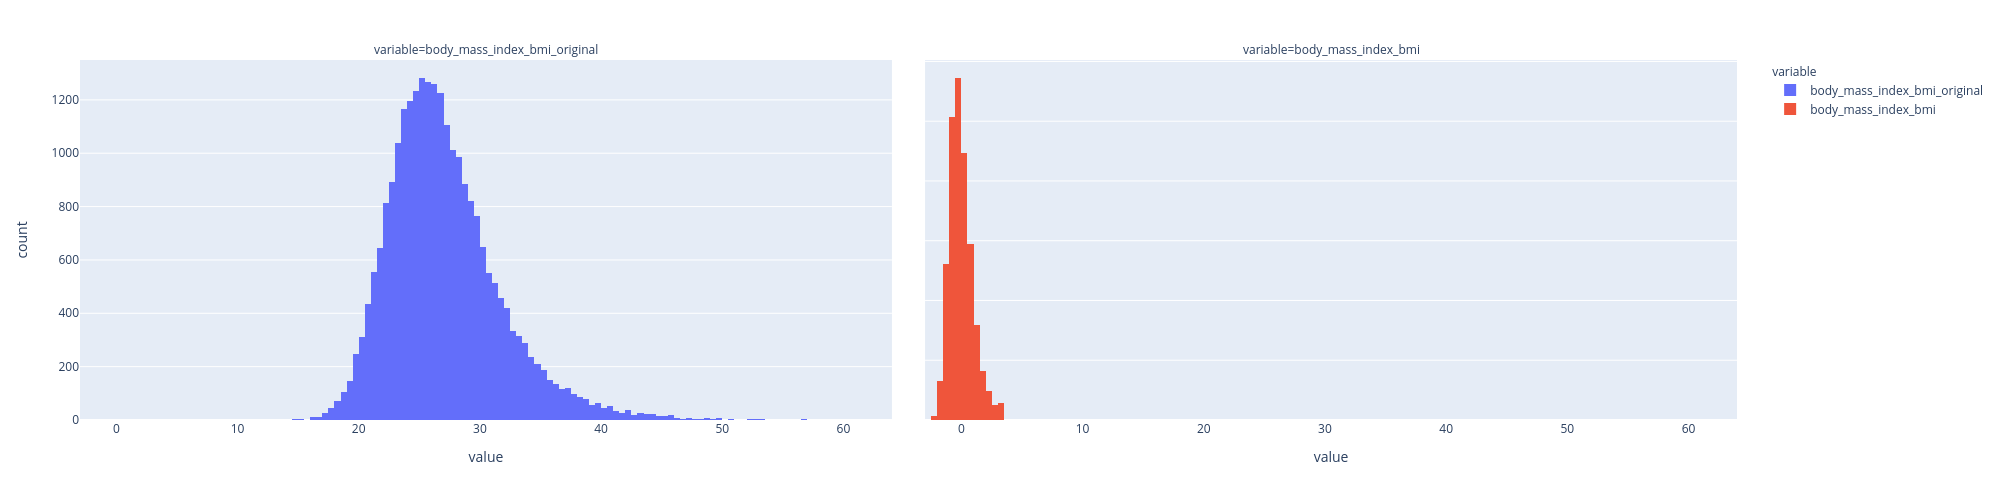

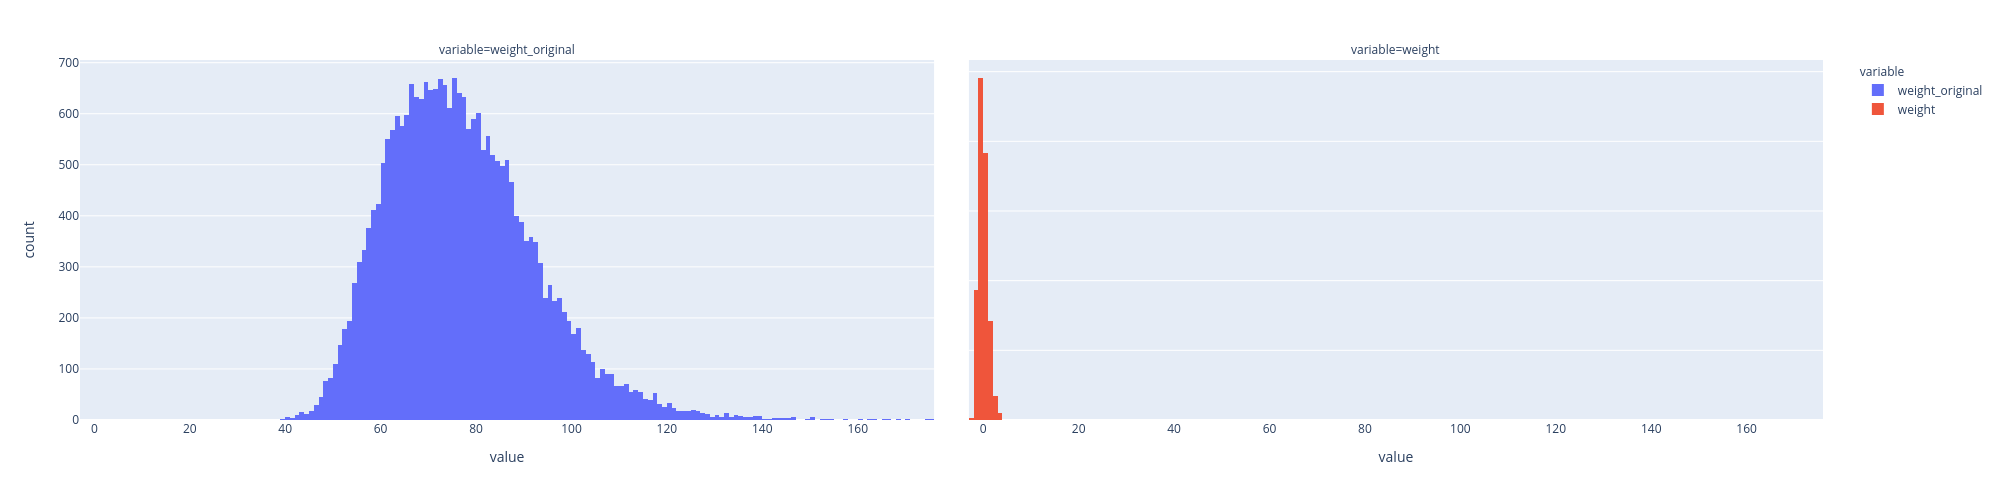

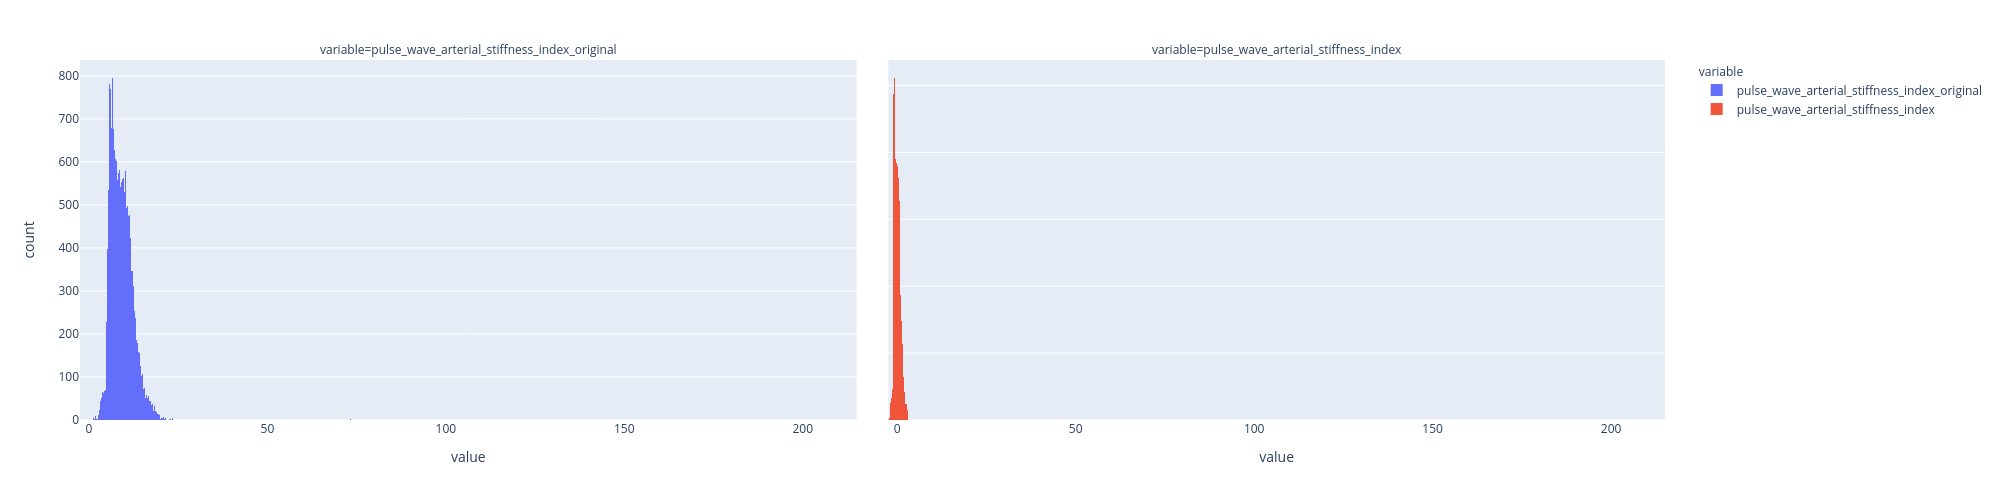

In [42]:
for col in range(3):
    import plotly.express as px
    fig = px.histogram(df, x=[content_original[col]] + [content[col]], facet_col = "variable")
    fig.update_yaxes(matches=None)
    fig.show()

    #fig = px.histogram(df_scaled.sample(50000), x=content[col])
    #fig.show(renderer="png")

In [12]:
import plotly.express as px


ERROR! Session/line number was not unique in database. History logging moved to new session 2142


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/steinfej/miniconda3/envs/python/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-d4f86b43bccd>", line 2, in <module>
    fig = px.histogram(df_original.sample(1000), x=content_original)
  File "/home/steinfej/miniconda3/envs/python/lib/python3.7/site-packages/plotly/express/_chart_types.py", line 456, in histogram
    layout_patch=dict(barmode=barmode, barnorm=barnorm),
  File "/home/steinfej/miniconda3/envs/python/lib/python3.7/site-packages/plotly/express/_core.py", line 2053, in make_figure
    fig.update_layout(template=args["template"], overwrite=True)
  File "/home/steinfej/miniconda3/envs/python/lib/python3.7/site-packages/plotly/basedatatypes.py", line 965, in update_layout
    self.layout.update(dict1, overwrite=overwrite, **kwargs)
  File "/home/steinfej/miniconda3/envs/python/lib/python3.7/site-packages/plotly/b

TypeError: object of type 'NoneType' has no len()

In [ ]:
for lab in labs:
    X = data[:1000, labs]
    

In [17]:
X.shape

(1000, 61)

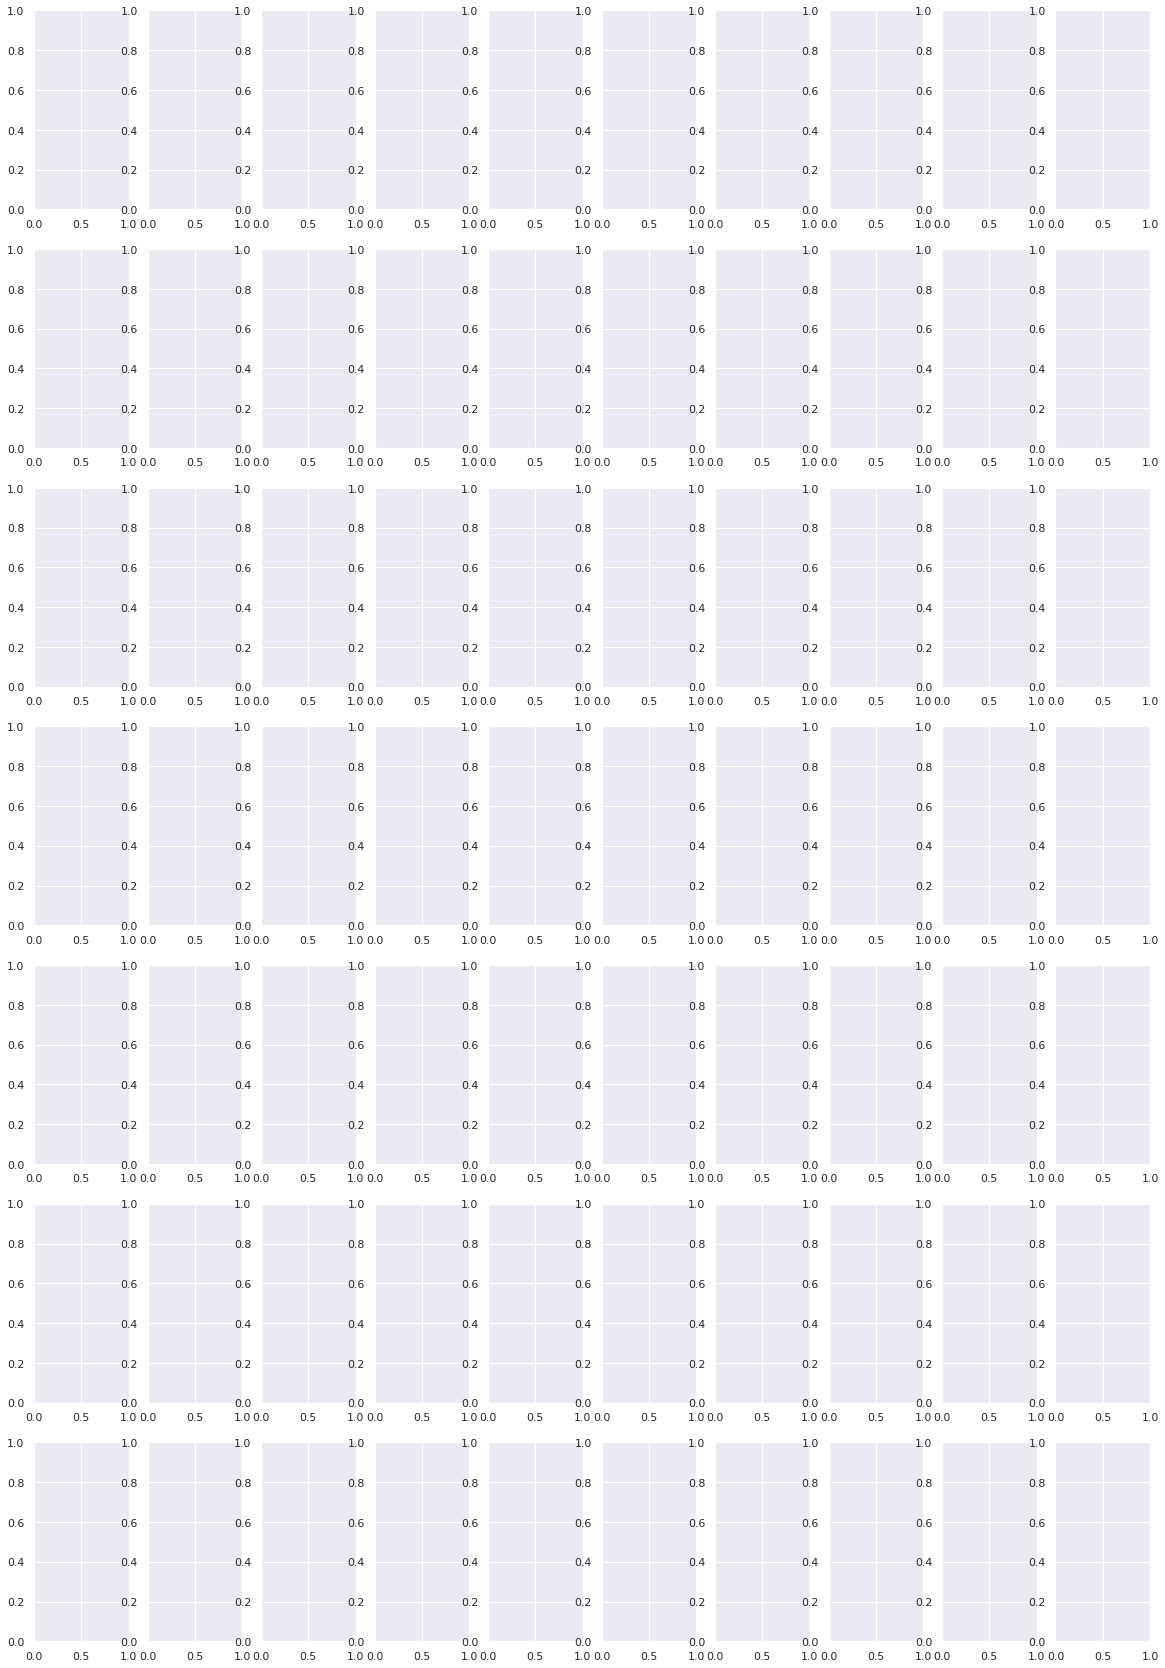

In [15]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,30)})
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=7, ncols=10);

In [16]:
for i in range(X.shape[1]):
    sns.histplot(X[:, i],ax=axes[i//7,i%10])

KeyboardInterrupt: 

In [20]:
isTarget=False
feature_dict = {}
for group in list(data.var[data.var.isTarget==isTarget].based_on.unique()):
    group_features = [x for x in list(data.var[(data.var.isTarget==isTarget) & (data.var.based_on == group)].index) if "_scaled" not in x]
    feature_dict[group] = group_features
pprint(feature_dict)

{'PGS': ['PGS000011',
         'PGS000013',
         'PGS000016',
         'PGS000018',
         'PGS000039',
         'PGS000057',
         'PGS000058',
         'PGS000059',
         'PGS000116',
         'PGS000117',
         'PGS000192',
         'PGS000296'],
 'basics': ['age_at_recruitment',
            'townsend_deprivation_index_at_recruitment',
            'ethnic_background_0.0',
            'ethnic_background_1.0',
            'ethnic_background_2.0',
            'ethnic_background_3.0',
            'ethnic_background_4.0',
            'ethnic_background',
            'sex'],
 'diagnoses': ['coronary_heart_disease',
               'myocardial_infarction',
               'stroke',
               'diabetes1',
               'diabetes2',
               'chronic_kidney_disease',
               'atrial_fibrillation',
               'migraine',
               'rheumatoid_arthritis',
               'systemic_lupus_erythematosus',
               'severe_mental_illness',
            

In [21]:
data.var

,dtype,isTarget,based_on,aggr_fn,recoding,NewLevels
PGS000011,numeric,False,PGS,NaN,{},
PGS000013,numeric,False,PGS,NaN,{},
PGS000016,numeric,False,PGS,NaN,{},
PGS000018,numeric,False,PGS,NaN,{},
PGS000039,numeric,False,PGS,NaN,{},
...,...,...,...,...,...,...
score_SCORE,numeric,True,nan,NaN,{},
score_ASCVD,numeric,True,nan,NaN,{},
score_QRISK3,numeric,True,nan,NaN,{},
score_COX_MACE_clinical,numeric,True,nan,NaN,{},


In [22]:
test = [
                'age_at_recruitment', 'standing_height', 'townsend_deprivation_index_at_recruitment',
                'diastolic_blood_pressure_automated_reading', 'systolic_blood_pressure_automated_reading',
                'body_mass_index_bmi','weight', 'cholesterol', 'hdl_cholesterol', 'ldl_direct', 'triglycerides',
                'overall_health_rating_0.0', 'overall_health_rating_1.0', 'overall_health_rating_2.0',
                'overall_health_rating_3.0', 'smoking_status_0.0', 'smoking_status_1.0', 'smoking_status_2.0',
                'ethnic_background_0.0', 'ethnic_background_1.0', 'ethnic_background_2.0', 'ethnic_background_3.0',
                'ethnic_background_4.0', 'sex', 'coronary_heart_disease', 'myocardial_infarction', 'stroke',
                'diabetes1', 'diabetes2', 'chronic_kidney_disease', 'atrial_fibrillation', 'migraine',
                'rheumatoid_arthritis', 'systemic_lupus_erythematosus', 'severe_mental_illness', 'erectile_dysfunction',
                'antihypertensives', 'statins', 'ass', 'atypical_antipsychotics', 'glucocorticoids']

In [23]:
len(test)

41

In [24]:
isTarget=True
feature_dict = {}
for group in list(data.var[data.var.isTarget==isTarget].based_on.unique()):
    group_features = [x for x in list(data.var[(data.var.isTarget==isTarget) & (data.var.based_on == group)].index) if "_scaled" not in x]
    feature_dict[group] = group_features
pprint(feature_dict)

{'diagnoses': ['hypoglycemic_event_due_to_diabetes'],
 'endpoints_death': ['death_allcause_event',
                     'death_allcause_event_time',
                     'death_cvd_event',
                     'death_cvd_event_time'],
 'endpoints_hospital': ['myocardial_infarction_event',
                        'myocardial_infarction_event_time',
                        'stroke_event',
                        'stroke_event_time',
                        'cancer_breast_event',
                        'cancer_breast_event_time',
                        'diabetes_event',
                        'diabetes_event_time',
                        'atrial_fibrillation_event',
                        'atrial_fibrillation_event_time',
                        'copd_event',
                        'copd_event_time',
                        'dementia_event',
                        'dementia_event_time'],
 'nan': ['score_SCORE',
         'score_ASCVD',
         'score_QRISK3',
         'score_COX_MA

In [25]:
output_categorical=False

In [26]:
        if output_categorical:
            basics = [
                'age_at_recruitment',
                'ethnic_background',
                'sex'
            ]
            questionnaire = [
                'overall_health_rating',
                'smoking_status',
                'alcohol_intake_frequency']
        else:
            basics = [
                'age_at_recruitment',
                'ethnic_background_0.0',
                'ethnic_background_1.0',
                'ethnic_background_2.0',
                'ethnic_background_3.0',
                'ethnic_background_4.0',
                'sex'
            ]
            questionnaire = [
                'overall_health_rating_0.0',
                'overall_health_rating_1.0',
                'overall_health_rating_2.0',
                'overall_health_rating_3.0',
                'smoking_status_0.0',
                'smoking_status_1.0',
                'smoking_status_2.0',
                'alcohol_intake_frequency_0.0',
                'alcohol_intake_frequency_1.0',
                'alcohol_intake_frequency_2.0',
                'alcohol_intake_frequency_3.0',
                'alcohol_intake_frequency_4.0',
                'alcohol_intake_frequency_5.0'
            ]
        measurements = [
            'body_mass_index_bmi',
            'weight',
            'pulse_wave_arterial_stiffness_index',
            'pulse_wave_reflection_index',
            'waist_circumference',
            'hip_circumference',
            'trunk_fat_percentage',
            'body_fat_percentage',
            'basal_metabolic_rate',
            'forced_vital_capacity_fvc_best_measure',
            'forced_expiratory_volume_in_1second_fev1_best_measure',
            'fev1_fvc_ratio_zscore',
            'peak_expiratory_flow_pef_f3064_0_2',
            'peak_expiratory_flow_pef_f3064_0_1',
            'peak_expiratory_flow_pef',
            'systolic_blood_pressure',
            'diastolic_blood_pressure',
            'pulse_rate'
        ]
        labs = [
            'basophill_count',
            'basophill_percentage',
            'eosinophill_count',
            'eosinophill_percentage',
            'haematocrit_percentage',
            'haemoglobin_concentration',
            'high_light_scatter_reticulocyte_count',
            'high_light_scatter_reticulocyte_percentage',
            'immature_reticulocyte_fraction',
            'lymphocyte_count',
            'lymphocyte_percentage',
            'mean_corpuscular_haemoglobin',
            'mean_corpuscular_haemoglobin_concentration',
            'mean_corpuscular_volume',
            'mean_platelet_thrombocyte_volume',
            'mean_reticulocyte_volume',
            'mean_sphered_cell_volume',
            'monocyte_count',
            'monocyte_percentage',
            'neutrophill_count',
            'neutrophill_percentage',
            'nucleated_red_blood_cell_count',
            'nucleated_red_blood_cell_percentage',
            'platelet_count',
            'platelet_crit',
            'platelet_distribution_width',
            'red_blood_cell_erythrocyte_count',
            'red_blood_cell_erythrocyte_distribution_width',
            'reticulocyte_count',
            'reticulocyte_percentage',
            'white_blood_cell_leukocyte_count',
            'alanine_aminotransferase',
            'albumin',
            'alkaline_phosphatase',
            'apolipoprotein_a',
            'apolipoprotein_b',
            'aspartate_aminotransferase',
            'creactive_protein',
            'calcium',
            'cholesterol',
            'creatinine',
            'cystatin_c',
            'direct_bilirubin',
            'gamma_glutamyltransferase',
            'glucose',
            'glycated_haemoglobin_hba1c',
            'hdl_cholesterol',
            'igf1',
            'ldl_direct',
            'lipoprotein_a',
            'oestradiol',
            'phosphate',
            'rheumatoid_factor',
            'shbg',
            'testosterone',
            'total_bilirubin',
            'total_protein',
            'triglycerides',
            'urate',
            'urea',
            'vitamin_d'
        ]
        family_history = [
            "fh_alzheimer's_disease/dementia",
            'fh_bowel_cancer',
            'fh_breast_cancer',
            'fh_chronic_bronchitis/emphysema',
            'fh_diabetes',
            'fh_heart_disease',
            'fh_high_blood_pressure',
            'fh_lung_cancer',
            "fh_parkinson's_disease",
            'fh_severe_depression',
            'fh_stroke'
        ]
        diagnoses = [
            'intestinal_infection',
            'bacterial_infection',
            'arthropathies',
            'viral_infection',
            'infections_specific_to_the_perinatal_period',
            'acute_upper_respiratory_infections',
            'mycoses',
            "kaposi's_sarcoma",
            'malaise_and_fatigue',
            'malignant_neoplasm_of_skin',
            'benign_neoplasm_of_respiratory_and_intrathoracic_organs',
            'benign_neoplasm_of_skin',
            'nonmalignant_breast_conditions',
            'anemias',
            'other_endocrine_disorders',
            'diabetes',
            'disorders_of_mineral_metabolism',
            'obesity',
            'respiratory_abnormalities',
            'disorders_of_lipoid_metabolism',
            'nonspecific_findings_on_examination_of_blood',
            'sleep_disorders',
            'male_genital_disorders',
            'cerebrovascular_disease',
            'cataract',
            'blindness_and_low_vision',
            'disorders_of_external_ear',
            'heart_valve_disorders',
            'ischemic_heart_disease',
            'cardiac_conduction_disorders',
            'heart_failure',
            'noninfectious_disorders_of_lymphatic_channels',
            'other_symptoms_of_respiratory_system',
            'disorders_of_stomach',
            'abdominal_pain',
            'abdominal_hernia',
            'liver_disease',
            'biliary_tract_disease',
            'bariatric_surgery',
            'complications',
            'other_hypertrophic_and_atrophic_conditions_of_skin',
            'symptoms_affecting_skin',
            'chronic_ulcer_of_skin',
            'gout',
            'osteoarthritis',
            'acquired_deformities',
            'pain_in_joint',
            'back_pain',
            'myalgia_and_myositis_unspecified',
            'symptoms_involving_nervous_and_musculoskeletal_systems',
            'pain_in_limb',
            'musculoskeletal_symptoms_referable_to_limbs',
            'congenital_musculoskeletal_anomalies',
            'other_symptoms/disorders_or_the_urinary_system',
            'urinary_calculus',
            'symptoms_involving_female_genital_tract',
            'other_nonmalignant_breast_conditions',
            'complications_of_the_puerperium',
            'complications_of_pregnancy',
            'postoperative_infection',
            'other_complications_of_pregnancy_nec',
            'excessive_vomiting_in_pregnancy',
            'infectious_and_parasitic_complications_affecting_pregnancy',
            'multiple_gestation',
            'late_pregnancy_and_failed_induction',
            'normal_delivery',
            'anemia_during_pregnancy',
            'maternal_complication_of_pregnancy_affecting_fetus_or_newborn',
            'gangrene',
            'abnormal_sputum',
            'symptoms_involving_head_and_neck',
            'nonspecific_chest_pain',
            'nausea_and_vomiting',
            'nonspecific_findings_on_examination_of_urine',
            'fever',
            'pain',
            'syncope_and_collapse',
            'shock',
            'hypothermia/chills',
            'abnormal_findings_examination_of_lungs',
            'contusion',
            'open_wound',
            'bone_marrow_or_stem_cell_transplant']
        medications=[
            'stomatological_preparations',
            'drugs_for_acid_related_disorders',
            'drugs_for_functional_gastrointestinal_disorders',
            'antiemetics_and_antinauseants',
            'bile_and_liver_therapy',
            'drugs_for_constipation',
            'antidiarrheals,_intestinal_antiinflammatory/antiinfective_agents',
            'antiobesity_preparations,_excl._diet_products',
            'digestives,_incl._enzymes',
            'drugs_used_in_diabetes',
            'vitamins',
            'mineral_supplements',
            'tonics',
            'anabolic_agents_for_systemic_use',
            'appetite_stimulants',
            'other_alimentary_tract_and_metabolism_products',
            'antithrombotic_agents',
            'antihemorrhagics',
            'antianemic_preparations',
            'blood_substitutes_and_perfusion_solutions',
            'other_hematological_agents',
            'cardiac_therapy',
            'antihypertensives',
            'diuretics',
            'peripheral_vasodilators',
            'vasoprotectives',
            'beta_blocking_agents',
            'calcium_channel_blockers',
            'agents_acting_on_the_renin-angiotensin_system',
            'lipid_modifying_agents',
            'antifungals_for_dermatological_use',
            'emollients_and_protectives',
            'preparations_for_treatment_of_wounds_and_ulcers',
            'antipruritics,_incl._antihistamines,_anesthetics,_etc.',
            'antipsoriatics',
            'antibiotics_and_chemotherapeutics_for_dermatological_use',
            'corticosteroids,_dermatological_preparations',
            'antiseptics_and_disinfectants',
            'medicated_dressings',
            'anti-acne_preparations',
            'other_dermatological_preparations',
            'gynecological_antiinfectives_and_antiseptics',
            'other_gynecologicals',
            'sex_hormones_and_modulators_of_the_genital_system',
            'urologicals',
            'pituitary_and_hypothalamic_hormones_and_analogues',
            'corticosteroids_for_systemic_use',
            'thyroid_therapy',
            'pancreatic_hormones',
            'calcium_homeostasis',
            'antibacterials_for_systemic_use',
            'antimycotics_for_systemic_use',
            'antimycobacterials',
            'antivirals_for_systemic_use',
            'immune_sera_and_immunoglobulins',
            'vaccines',
            'antineoplastic_agents',
            'endocrine_therapy',
            'immunostimulants',
            'immunosuppressants',
            'antiinflammatory_and_antirheumatic_products',
            'topical_products_for_joint_and_muscular_pain',
            'muscle_relaxants',
            'antigout_preparations',
            'drugs_for_treatment_of_bone_diseases',
            'other_drugs_for_disorders_of_the_musculo-skeletal_system',
            'anesthetics',
            'analgesics',
            'antiepileptics',
            'anti-parkinson_drugs',
            'psycholeptics',
            'psychoanaleptics',
            'other_nervous_system_drugs',
            'antiprotozoals',
            'anthelmintics',
            'ectoparasiticides,_incl._scabicides,_insecticides_and_repellents',
            'nasal_preparations',
            'throat_preparations',
            'drugs_for_obstructive_airway_diseases',
            'cough_and_cold_preparations',
            'antihistamines_for_systemic_use',
            'other_respiratory_system_products',
            'ophthalmologicals',
            'otologicals',
            'ophthalmological_and_otological_preparations',
            'allergens',
            'all_other_therapeutic_products',
            'diagnostic_agents',
            'general_nutrients',
            'all_other_non-therapeutic_products',
            'contrast_media',
            'diagnostic_radiopharmaceuticals',
            'therapeutic_radiopharmaceuticals',
            'surgical_dressings'
        ]

        pgs = [
            'PGS000011',
             'PGS000013',
             'PGS000016',
             'PGS000018',
             'PGS000039',
             'PGS000057',
             'PGS000058',
             'PGS000059',
             'PGS000116',
             'PGS000117',
             'PGS000192',
             'PGS000296']
        
        feature_dict = {
            "pgs": pgs,
            "basics": basics,
            "questionnaire": questionnaire ,
            "measurements": measurements,
            "labs": labs,
            "family_history": family_history,
            "medications": medications,
            "diagnoses": diagnoses,
        }

        #features = self.pgs + self.features

In [27]:
features = [f for group_list in feature_dict.values() for f in group_list]

In [28]:
data.X[1, :]

array([0.3990433 , 0.4383982 , 0.85513496, ...,        nan,        nan,
              nan], dtype=float32)

In [29]:
data

AnnData object with n_obs × n_vars = 319108 × 4073
    obs: 'eid'
    var: 'dtype', 'isTarget', 'based_on', 'aggr_fn', 'recoding', 'NewLevels'

In [30]:
for group, group_list in feature_dict.items():
    for f in group_list:
        print(f)

PGS000011
PGS000013
PGS000016
PGS000018
PGS000039
PGS000057
PGS000058
PGS000059
PGS000116
PGS000117
PGS000192
PGS000296
age_at_recruitment
ethnic_background_0.0
ethnic_background_1.0
ethnic_background_2.0
ethnic_background_3.0
ethnic_background_4.0
sex
overall_health_rating_0.0
overall_health_rating_1.0
overall_health_rating_2.0
overall_health_rating_3.0
smoking_status_0.0
smoking_status_1.0
smoking_status_2.0
alcohol_intake_frequency_0.0
alcohol_intake_frequency_1.0
alcohol_intake_frequency_2.0
alcohol_intake_frequency_3.0
alcohol_intake_frequency_4.0
alcohol_intake_frequency_5.0
body_mass_index_bmi
weight
pulse_wave_arterial_stiffness_index
pulse_wave_reflection_index
waist_circumference
hip_circumference
trunk_fat_percentage
body_fat_percentage
basal_metabolic_rate
forced_vital_capacity_fvc_best_measure
forced_expiratory_volume_in_1second_fev1_best_measure
fev1_fvc_ratio_zscore
peak_expiratory_flow_pef_f3064_0_2
peak_expiratory_flow_pef_f3064_0_1
peak_expiratory_flow_pef
systolic_bl

In [31]:
feature_dict

{'pgs': ['PGS000011',
  'PGS000013',
  'PGS000016',
  'PGS000018',
  'PGS000039',
  'PGS000057',
  'PGS000058',
  'PGS000059',
  'PGS000116',
  'PGS000117',
  'PGS000192',
  'PGS000296'],
 'basics': ['age_at_recruitment',
  'ethnic_background_0.0',
  'ethnic_background_1.0',
  'ethnic_background_2.0',
  'ethnic_background_3.0',
  'ethnic_background_4.0',
  'sex'],
 'questionnaire': ['overall_health_rating_0.0',
  'overall_health_rating_1.0',
  'overall_health_rating_2.0',
  'overall_health_rating_3.0',
  'smoking_status_0.0',
  'smoking_status_1.0',
  'smoking_status_2.0',
  'alcohol_intake_frequency_0.0',
  'alcohol_intake_frequency_1.0',
  'alcohol_intake_frequency_2.0',
  'alcohol_intake_frequency_3.0',
  'alcohol_intake_frequency_4.0',
  'alcohol_intake_frequency_5.0'],
 'measurements': ['body_mass_index_bmi',
  'weight',
  'pulse_wave_arterial_stiffness_index',
  'pulse_wave_reflection_index',
  'waist_circumference',
  'hip_circumference',
  'trunk_fat_percentage',
  'body_fat_pe

In [32]:
data.var.index[data.var.based_on == "PGS"]

Index(['PGS000011', 'PGS000013', 'PGS000016', 'PGS000018', 'PGS000039',
       'PGS000057', 'PGS000058', 'PGS000059', 'PGS000116', 'PGS000117',
       'PGS000192', 'PGS000296', 'PGS000011_scaled', 'PGS000013_scaled',
       'PGS000016_scaled', 'PGS000018_scaled', 'PGS000039_scaled',
       'PGS000057_scaled', 'PGS000058_scaled', 'PGS000059_scaled',
       'PGS000116_scaled', 'PGS000117_scaled', 'PGS000192_scaled',
       'PGS000296_scaled'],
      dtype='object')

In [33]:
data.var[data.var.isTarget=="False"].index.to_list()

[]

In [2]:
data = pd.read_feather(os.path.join(project_path, dataset_path, project_name, "baseline.feather"))
data_description = pd.read_feather(os.path.join(project_path, dataset_path, project_name, "baseline_description.feather"))

In [3]:
covariates = data_description[data_description.isTarget=="False"].covariate.to_list()[1:]
targets = data_description[data_description.isTarget=="True"].covariate.to_list()
data_description

,covariate,dtype,isTarget,based_on,aggr_fn
0,eid,integer,False,admin,NaN
1,PGS000011,numeric,False,PGS,NaN
2,PGS000013,numeric,False,PGS,NaN
3,PGS000016,numeric,False,PGS,NaN
4,PGS000018,numeric,False,PGS,NaN
...,...,...,...,...,...
307,ASCVD_event_time,numeric,True,score_ASCVD,NaN
308,QRISK3_event,integer,True,score_QRISK3,NaN
309,QRISK3_event_time,numeric,True,score_QRISK3,NaN
310,MACE_event,integer,True,score_MACE,NaN


## Visualize missing values

In [5]:
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import seaborn as sns
import pandas as pd
import warnings

def nullity_sort(df, sort=None, axis='columns'):
    """
    Sorts a DataFrame according to its nullity, in either ascending or descending order.
    :param df: The DataFrame object being sorted.
    :param sort: The sorting method: either "ascending", "descending", or None (default).
    :return: The nullity-sorted DataFrame.
    """
    if sort is None:
        return df
    elif sort not in ['ascending', 'descending']:
        raise ValueError('The "sort" parameter must be set to "ascending" or "descending".')

    if axis not in ['rows', 'columns']:
        raise ValueError('The "axis" parameter must be set to "rows" or "columns".')

    if axis == 'columns':
        if sort == 'ascending':
            return df.iloc[np.argsort(df.count(axis='columns').values), :]
        elif sort == 'descending':
            return df.iloc[np.flipud(np.argsort(df.count(axis='columns').values)), :]
    elif axis == 'rows':
        if sort == 'ascending':
            return df.iloc[:, np.argsort(df.count(axis='rows').values)]
        elif sort == 'descending':
            return df.iloc[:, np.flipud(np.argsort(df.count(axis='rows').values))]


def nullity_filter(df, filter=None, p=0, n=0):
    """
    Filters a DataFrame according to its nullity, using some combination of 'top' and 'bottom' numerical and
    percentage values. Percentages and numerical thresholds can be specified simultaneously: for example,
    to get a DataFrame with columns of at least 75% completeness but with no more than 5 columns, use
    `nullity_filter(df, filter='top', p=.75, n=5)`.
    :param df: The DataFrame whose columns are being filtered.
    :param filter: The orientation of the filter being applied to the DataFrame. One of, "top", "bottom",
    or None (default). The filter will simply return the DataFrame if you leave the filter argument unspecified or
    as None.
    :param p: A completeness ratio cut-off. If non-zero the filter will limit the DataFrame to columns with at least p
    completeness. Input should be in the range [0, 1].
    :param n: A numerical cut-off. If non-zero no more than this number of columns will be returned.
    :return: The nullity-filtered `DataFrame`.
    """
    if filter == 'top':
        if p:
            df = df.iloc[:, [c >= p for c in df.count(axis='rows').values / len(df)]]
        if n:
            df = df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[-n:])]
    elif filter == 'bottom':
        if p:
            df = df.iloc[:, [c <= p for c in df.count(axis='rows').values / len(df)]]
        if n:
            df = df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[:n])]
    return df

def matrix(df,
           filter=None, n=0, p=0, sort=None,
           figsize=(25, 10), width_ratios=(15, 1), color=(0.25, 0.25, 0.25),
           fontsize=16, labels=None, sparkline=True, inline=False,
           freq=None, ax=None):
    """
    A matrix visualization of the nullity of the given DataFrame.
    :param df: The `DataFrame` being mapped.
    :param filter: The filter to apply to the heatmap. Should be one of "top", "bottom", or None (default).
    :param n: The max number of columns to include in the filtered DataFrame.
    :param p: The max percentage fill of the columns in the filtered DataFrame.
    :param sort: The row sort order to apply. Can be "ascending", "descending", or None.
    :param figsize: The size of the figure to display.
    :param fontsize: The figure's font size. Default to 16.
    :param labels: Whether or not to display the column names. Defaults to the underlying data labels when there are
    50 columns or less, and no labels when there are more than 50 columns.
    :param sparkline: Whether or not to display the sparkline. Defaults to True.
    :param width_ratios: The ratio of the width of the matrix to the width of the sparkline. Defaults to `(15, 1)`.
    Does nothing if `sparkline=False`.
    :param color: The color of the filled columns. Default is `(0.25, 0.25, 0.25)`.
    :return: If `inline` is False, the underlying `matplotlib.figure` object. Else, nothing.
    """
    df = nullity_filter(df, filter=filter, n=n, p=p)
    df = nullity_sort(df, sort=sort, axis='columns')

    height = df.shape[0]
    width = df.shape[1]

    # z is the color-mask array, g is a NxNx3 matrix. Apply the z color-mask to set the RGB of each pixel.
    z = df.notnull().values
    g = np.zeros((height, width, 3))

    g[z < 0.5] = [1, 1, 1]
    g[z > 0.5] = color

    # Set up the matplotlib grid layout. A unary subplot if no sparkline, a left-right splot if yes sparkline.
    if ax is None:
        plt.figure(figsize=figsize)
        if sparkline:
            gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)
            gs.update(wspace=0.08)
            ax1 = plt.subplot(gs[1])
        else:
            gs = gridspec.GridSpec(1, 1)
        ax0 = plt.subplot(gs[0])
    else:
        if sparkline is not False:
            warnings.warn(
                "Plotting a sparkline on an existing axis is not currently supported. "
                "To remove this warning, set sparkline=False."
            )
            sparkline = False
        ax0 = ax

    # Create the nullity plot.
    ax0.imshow(g, interpolation='none')

    # Remove extraneous default visual elements.
    ax0.set_aspect('auto')
    ax0.grid(b=False)
    ax0.xaxis.tick_top()
    ax0.xaxis.set_ticks_position('none')
    ax0.yaxis.set_ticks_position('none')
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)

    # Set up and rotate the column ticks. The labels argument is set to None by default. If the user specifies it in
    # the argument, respect that specification. Otherwise display for <= 50 columns and do not display for > 50.
    if labels or (labels is None and len(df.columns) <= 50):
        ha = 'left'
        ax0.set_xticks(list(range(0, width)))
        ax0.set_xticklabels(list(df.columns), rotation=45, ha=ha, fontsize=fontsize)
    else:
        ax0.set_xticks([])

    # Adds Timestamps ticks if freq is not None, else set up the two top-bottom row ticks.
    if freq:
        ts_list = []

        if type(df.index) == pd.PeriodIndex:
            ts_array = pd.date_range(df.index.to_timestamp().date[0],
                                     df.index.to_timestamp().date[-1],
                                     freq=freq).values

            ts_ticks = pd.date_range(df.index.to_timestamp().date[0],
                                     df.index.to_timestamp().date[-1],
                                     freq=freq).map(lambda t:
                                                    t.strftime('%Y-%m-%d'))

        elif type(df.index) == pd.DatetimeIndex:
            ts_array = pd.date_range(df.index[0], df.index[-1],
                                     freq=freq).values

            ts_ticks = pd.date_range(df.index[0], df.index[-1],
                                     freq=freq).map(lambda t:
                                                    t.strftime('%Y-%m-%d'))
        else:
            raise KeyError('Dataframe index must be PeriodIndex or DatetimeIndex.')
        try:
            for value in ts_array:
                ts_list.append(df.index.get_loc(value))
        except KeyError:
            raise KeyError('Could not divide time index into desired frequency.')

        ax0.set_yticks(ts_list)
        ax0.set_yticklabels(ts_ticks, fontsize=int(fontsize / 16 * 20), rotation=0)
    else:
        ax0.set_yticks([0, df.shape[0] - 1])
        ax0.set_yticklabels([1, df.shape[0]], fontsize=int(fontsize / 16 * 20), rotation=0)

    if sparkline:
        # Calculate row-wise completeness for the sparkline.
        completeness_srs = df.notnull().astype(bool).sum(axis=1)
        x_domain = list(range(0, height))
        y_range = list(reversed(completeness_srs.values))
        min_completeness = min(y_range)
        max_completeness = max(y_range)
        min_completeness_index = y_range.index(min_completeness)
        max_completeness_index = y_range.index(max_completeness)

        # Set up the sparkline, remove the border element.
        ax1.grid(b=False)
        ax1.set_aspect('auto')
        # GH 25
        if int(mpl.__version__[0]) <= 1:
            ax1.set_axis_bgcolor((1, 1, 1))
        else:
            ax1.set_facecolor((1, 1, 1))
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.set_ymargin(0)

        # Plot sparkline---plot is sideways so the x and y axis are reversed.
        ax1.plot(y_range, x_domain, color=color)

        if labels:
            # Figure out what case to display the label in: mixed, upper, lower.
            label = 'Data Completeness'
            if str(df.columns[0]).islower():
                label = label.lower()
            if str(df.columns[0]).isupper():
                label = label.upper()

            # Set up and rotate the sparkline label.
            ha = 'left'
            ax1.set_xticks([min_completeness + (max_completeness - min_completeness) / 2])
            ax1.set_xticklabels([label], rotation=45, ha=ha, fontsize=fontsize)
            ax1.xaxis.tick_top()
            ax1.set_yticks([])
        else:
            ax1.set_xticks([])
            ax1.set_yticks([])

        # Add maximum and minimum labels, circles.
        ax1.annotate(max_completeness,
                     xy=(max_completeness, max_completeness_index),
                     xytext=(max_completeness + 2, max_completeness_index),
                     fontsize=int(fontsize / 16 * 14),
                     va='center',
                     ha='left')
        ax1.annotate(min_completeness,
                     xy=(min_completeness, min_completeness_index),
                     xytext=(min_completeness - 2, min_completeness_index),
                     fontsize=int(fontsize / 16 * 14),
                     va='center',
                     ha='right')

        ax1.set_xlim([min_completeness - 2, max_completeness + 2])  # Otherwise the circles are cut off.
        ax1.plot([min_completeness], [min_completeness_index], '.', color=color, markersize=10.0)
        ax1.plot([max_completeness], [max_completeness_index], '.', color=color, markersize=10.0)

        # Remove tick mark (only works after plotting).
        ax1.xaxis.set_ticks_position('none')

    if inline:
        warnings.warn(
            "The 'inline' argument has been deprecated, and will be removed in a future version "
            "of missingno."
        )
        plt.show()
    else:
        return ax0


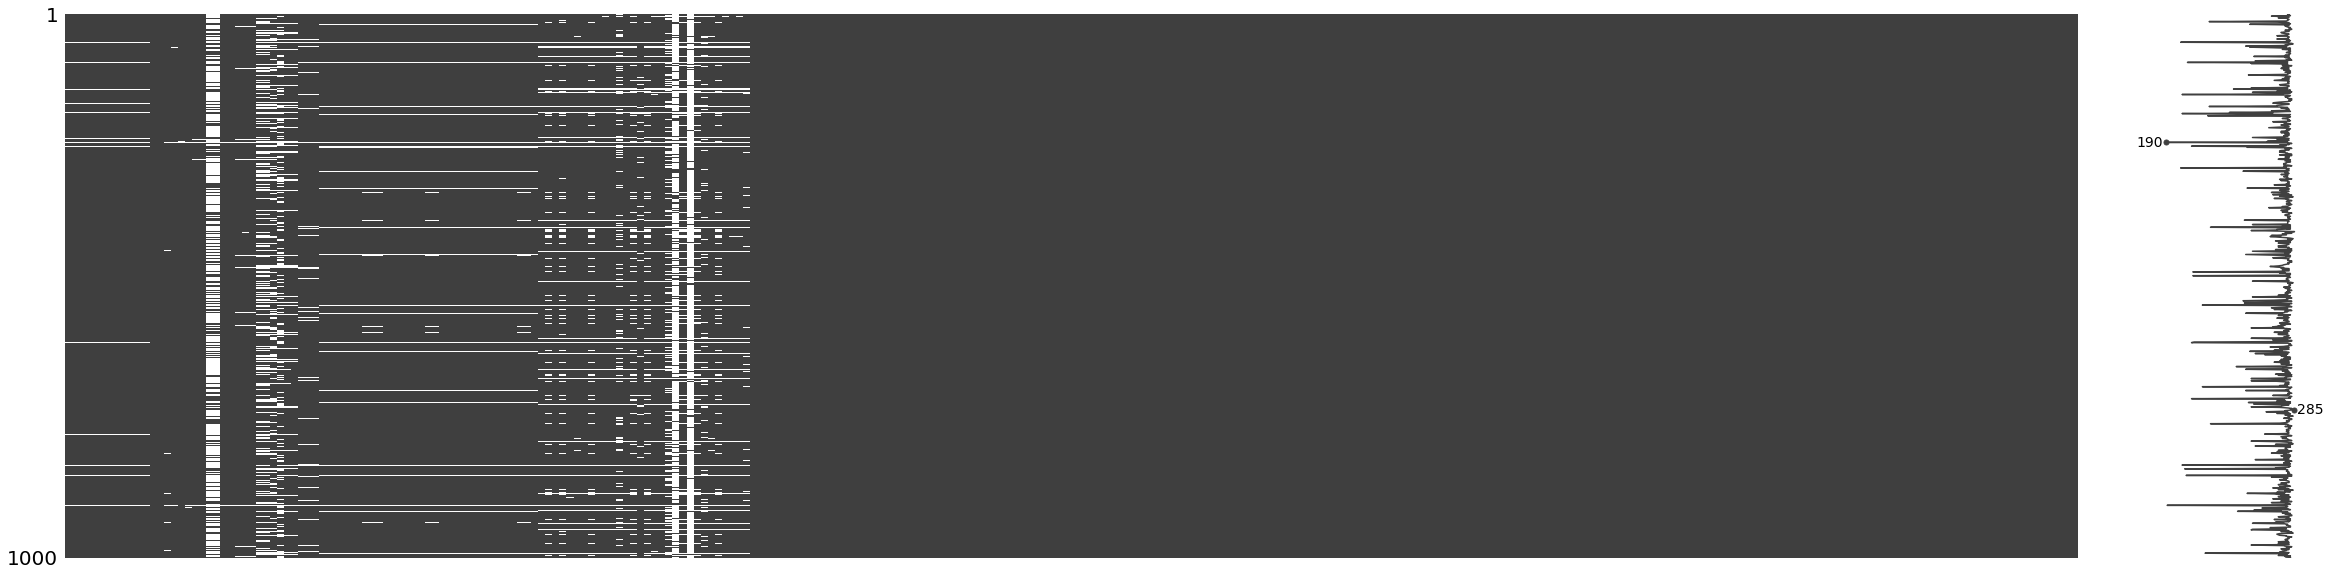

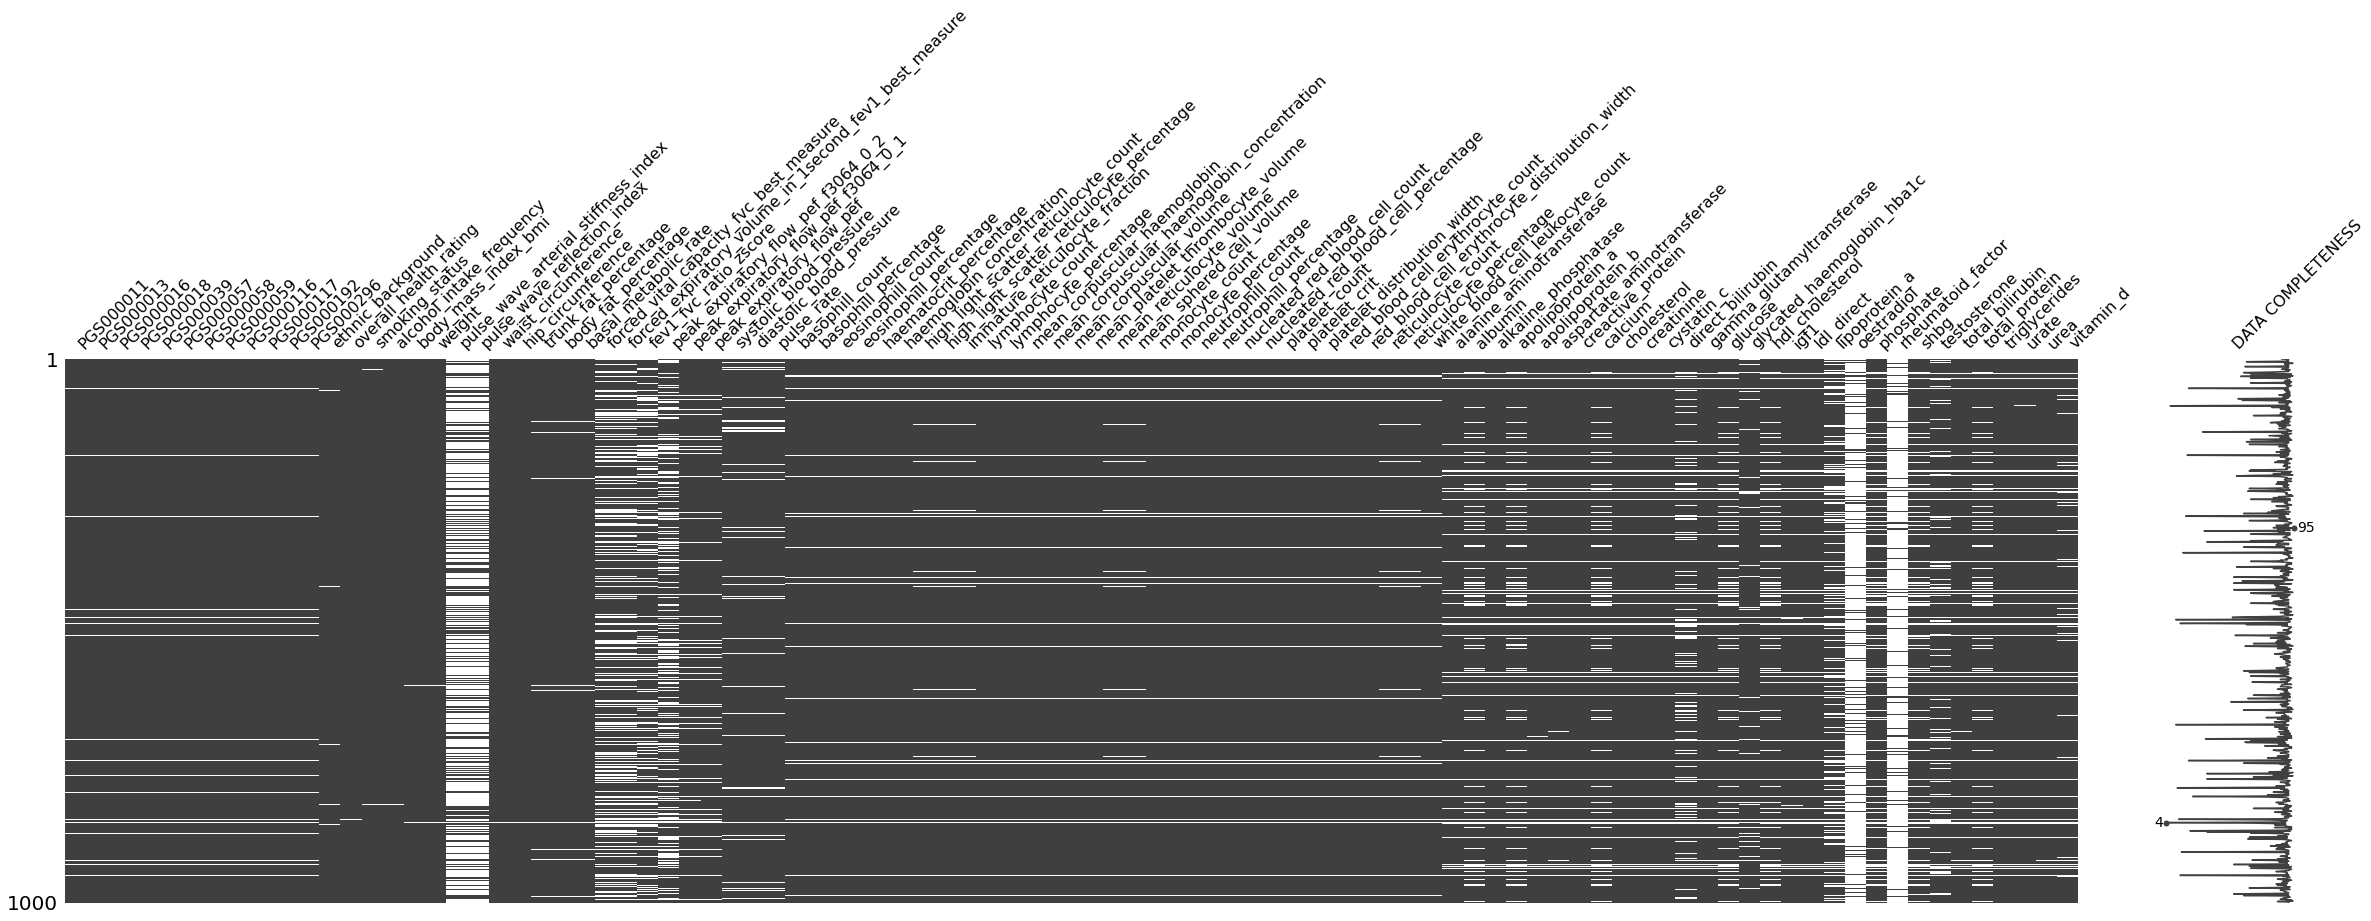

In [6]:
import missingno as msno
%matplotlib inline
fig = matrix(data[covariates].sample(1000), sparkline=True, figsize=(40, 10))

missing = data.columns[data.isnull().any()]
fig = matrix(data[missing].sample(1000), sparkline=True, labels=True, figsize=(40, 10))

## Preprocessing

In [7]:
cat_features = data.select_dtypes(['O', "category"]).columns.to_list()
cat_idx = data.columns.get_indexer(cat_features)

In [8]:
# Show Categories
df = data
for col in cat_features:
    print(df[col].unique())

[Female, Male]
Categories (2, object): [Female < Male]
['White' 'Black' None 'Asien' 'Mixed' 'Chinese']
['Fair' 'Good' 'Poor' 'Excellent' None]
['Current' 'Previous' 'Never' None]
['Once or twice a week' 'Three or four times a week'
 'One to three times a month' 'Daily or almost daily'
 'Special occasions only' 'Never' None]


In [10]:
# Encode Categories
from category_encoders import *
enc = OrdinalEncoder(cols=cat_features, handle_missing="return_nan", handle_unknown="return_nan")
enc.fit(data)
data_tf = enc.transform(data)

df = data_tf
for col in cat_features: print(df[col].unique())

[1. 2.]
[ 1.  2. nan  4.  5.  6.]
[ 1.  2.  3.  4. nan]
[ 1.  2.  3. nan]
[ 1.  2.  3.  4.  5.  6. nan]


## Imputation with Missforest

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

### Imputation FAST and ALRIGHT

In [54]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(n_estimators=20, max_features='sqrt', bootstrap=True, max_samples=0.1, n_jobs=20)
imputer = IterativeImputer(estimator=estimator, max_iter=10, verbose=2, skip_complete=True, n_nearest_features=20)

In [55]:
%%time
# fit to training data
imputer.fit(data_tf)

[IterativeImputer] Completing matrix with shape (502504, 312)
[IterativeImputer] Ending imputation round 1/10, elapsed time 96.26
[IterativeImputer] Change: 5025.888209169452, scaled tolerance: 6025.198 
[IterativeImputer] Early stopping criterion reached.
CPU times: user 13min 49s, sys: 28 s, total: 14min 17s
Wall time: 2min 2s


IterativeImputer(estimator=RandomForestRegressor(max_features='sqrt',
                                                 max_samples=0.1,
                                                 n_estimators=20, n_jobs=20),
                 n_nearest_features=20, skip_complete=True, verbose=2)

### Imputation PERFECT but SLOW

In [46]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(n_estimators=50, max_features='sqrt', bootstrap=True, max_samples=0.1, n_jobs=20, oob_score=True)
imputer = IterativeImputer(estimator=estimator, max_iter=10, verbose=2, skip_complete=True)

In [47]:
%%time
# fit to training data
imputer.fit(data_tf)

[IterativeImputer] Completing matrix with shape (502504, 312)
[IterativeImputer] Ending imputation round 1/10, elapsed time 794.15
[IterativeImputer] Change: 3884.692167206953, scaled tolerance: 6025.198 
[IterativeImputer] Early stopping criterion reached.
CPU times: user 1h 8min 22s, sys: 6min 54s, total: 1h 15min 17s
Wall time: 14min


IterativeImputer(estimator=RandomForestRegressor(max_features='sqrt',
                                                 max_samples=0.1,
                                                 n_estimators=50, n_jobs=20),
                 skip_complete=True, verbose=2)

### Apply Imputation

In [56]:
# transform training data
data_imp_tf_array = imputer.transform(data_tf)

[IterativeImputer] Completing matrix with shape (502504, 312)
[IterativeImputer] Ending imputation round 1/1, elapsed time 16.25


In [57]:
# transform back to df
data_imp_tf = pd.DataFrame(data=data_imp_tf_array, columns=data.columns)
for col in cat_features: data_imp_tf[col] = data_imp_tf[col].astype(int)

In [58]:
# Inverse Transform labels
data_imp = enc.inverse_transform(data_imp_tf)

## Visualize Post Imputation

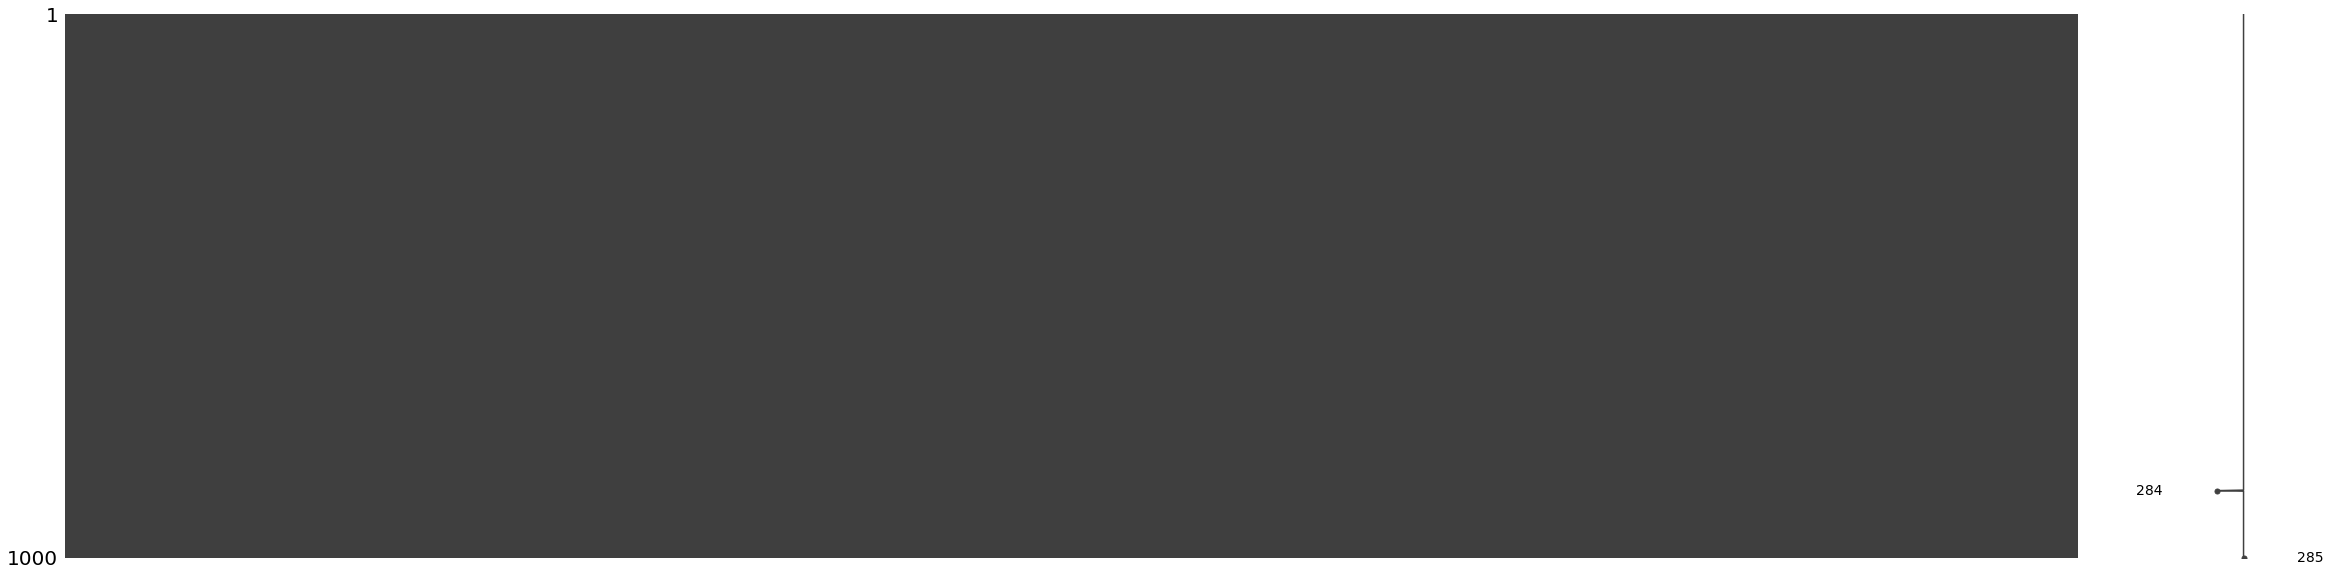

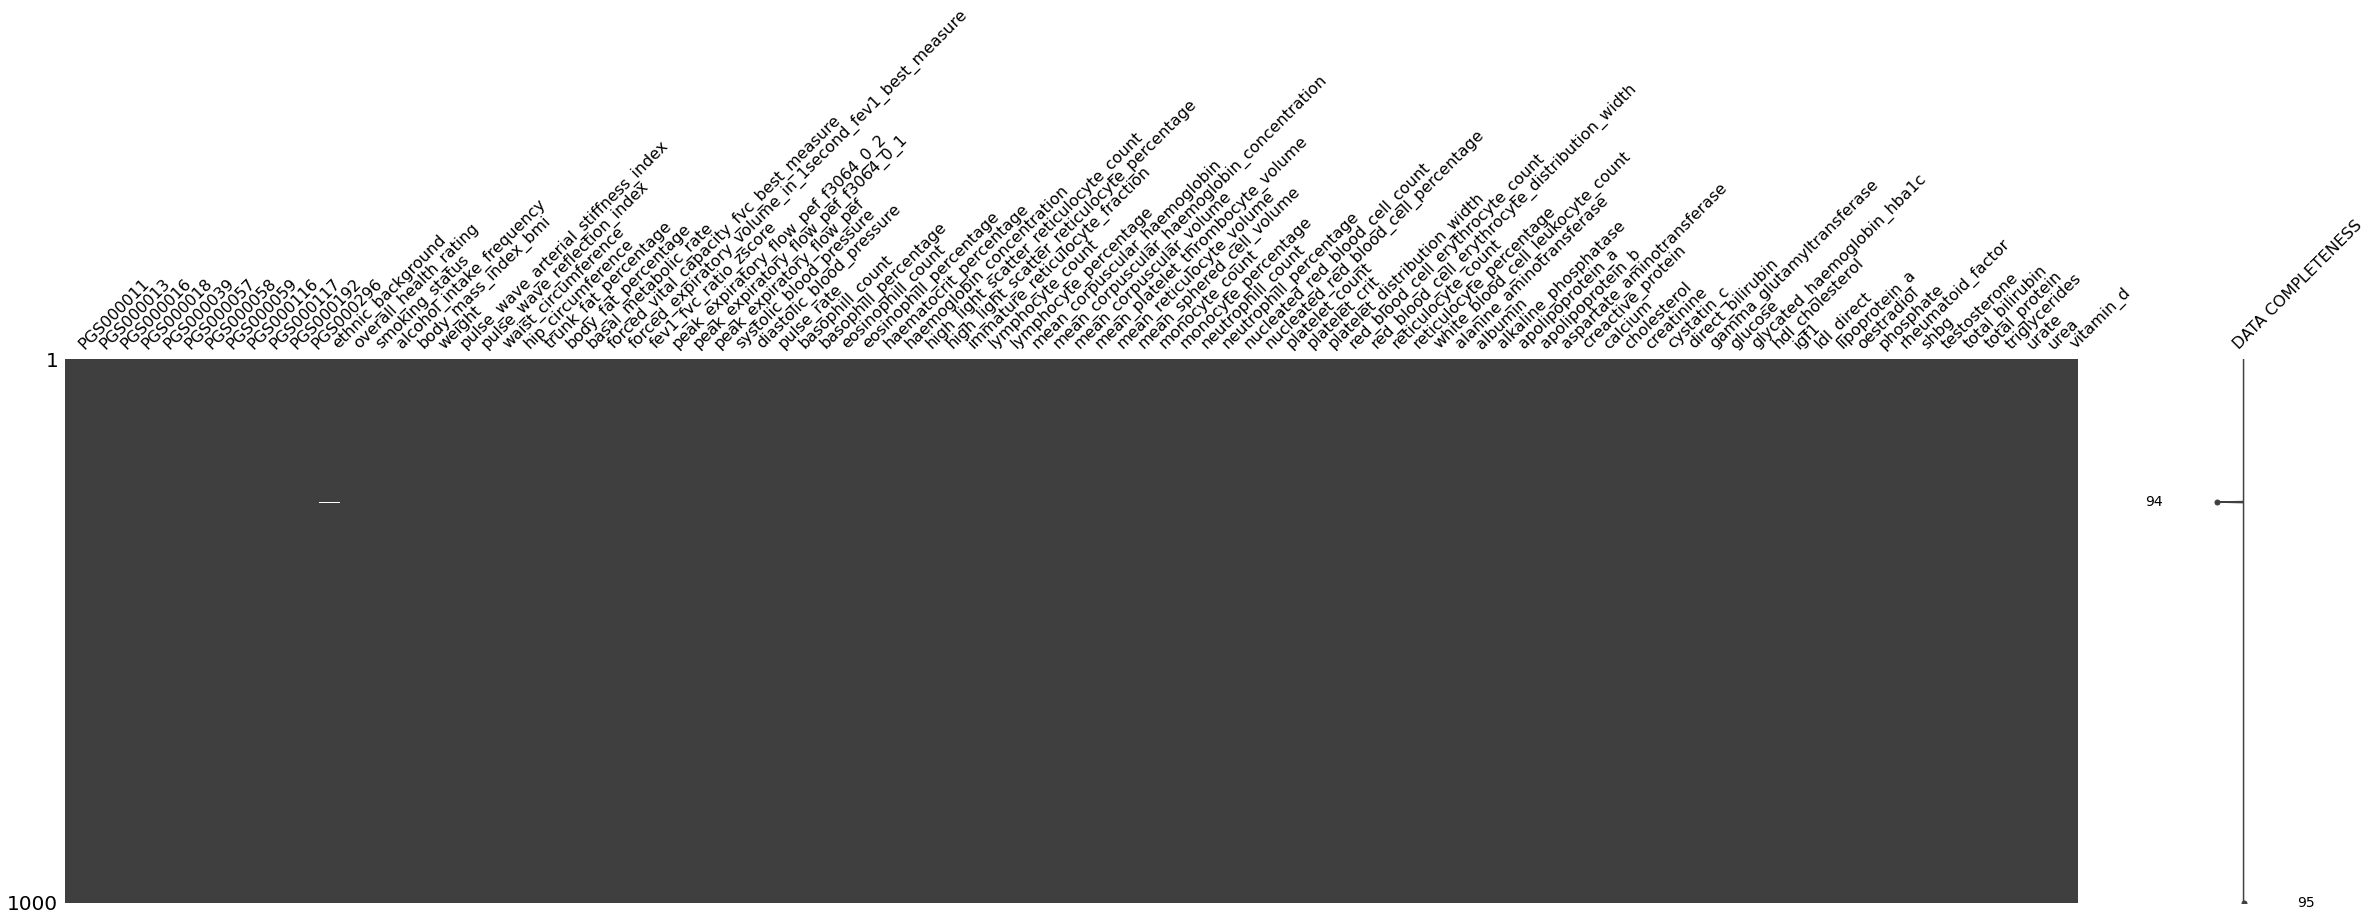

In [59]:
import missingno as msno
%matplotlib inline
fig = matrix(data_imp[covariates].sample(1000), sparkline=True, figsize=(40, 10))

missing = data.columns[data.isnull().any()]
fig = matrix(data_imp[missing].sample(1000), sparkline=True, labels=True, figsize=(40, 10))

In [61]:
data_tf.ethnic_background.unique()

array([ 1.,  2., nan,  4.,  5.,  6.])

## Write to disk

In [62]:
shared_project_path = os.path.join(shared_path, project_name)
pathlib.Path(shared_project_path).mkdir(parents=True, exist_ok=True)
write_path = os.path.join(shared_project_path, "baseline_imputed")
data_imp.to_feather(write_path+".feather")
data_imp.to_csv(write_path+".csv", index=False, na_rep='NA')
print(write_path)

/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/all/cvd_big/baseline_imputed


## Plus 1 year 

In [63]:
data_imp_yearplus1 = data_imp.copy()
event_time_cols = [s for s in data.columns.to_list() if "_event_time" in s] 
data_imp[event_time_cols].head()

,myocardial_infarction_event_time,stroke_event_time,cancer_breast_event_time,diabetes_event_time,atrial_fibrillation_event_time,copd_event_time,dementia_event_time,death_allcause_event_time,death_cvd_event_time,SCORE_event_time,ASCVD_event_time,QRISK3_event_time,MACE_event_time
0,10.335387,10.335387,10.335387,10.335387,10.335387,10.335387,10.335387,10.625599,10.625599,10.625599,10.335387,10.335387,10.335387
1,12.065708,12.065708,12.065708,12.065708,12.065708,12.065708,12.065708,12.355921,12.355921,12.355921,12.065708,12.065708,12.065708
2,11.337440,11.337440,11.337440,11.337440,11.337440,11.337440,11.337440,11.627652,11.627652,11.627652,7.969884,7.969884,11.337440
3,5.122519,10.778919,10.778919,10.778919,10.778919,0.292950,10.778919,11.069131,11.069131,11.069131,5.122519,5.122519,5.122519
4,13.760438,13.760438,13.760438,4.722793,13.760438,4.840520,13.760438,14.050650,14.050650,14.050650,13.760438,13.760438,13.760438


In [64]:
for col in event_time_cols: data_imp_yearplus1[col] = data_imp_yearplus1[col]+1
data_imp_yearplus1[event_time_cols].head()

,myocardial_infarction_event_time,stroke_event_time,cancer_breast_event_time,diabetes_event_time,atrial_fibrillation_event_time,copd_event_time,dementia_event_time,death_allcause_event_time,death_cvd_event_time,SCORE_event_time,ASCVD_event_time,QRISK3_event_time,MACE_event_time
0,11.335387,11.335387,11.335387,11.335387,11.335387,11.335387,11.335387,11.625599,11.625599,11.625599,11.335387,11.335387,11.335387
1,13.065708,13.065708,13.065708,13.065708,13.065708,13.065708,13.065708,13.355921,13.355921,13.355921,13.065708,13.065708,13.065708
2,12.337440,12.337440,12.337440,12.337440,12.337440,12.337440,12.337440,12.627652,12.627652,12.627652,8.969884,8.969884,12.337440
3,6.122519,11.778919,11.778919,11.778919,11.778919,1.292950,11.778919,12.069131,12.069131,12.069131,6.122519,6.122519,6.122519
4,14.760438,14.760438,14.760438,5.722793,14.760438,5.840520,14.760438,15.050650,15.050650,15.050650,14.760438,14.760438,14.760438


In [66]:
shared_project_path = os.path.join(shared_path, project_name)
pathlib.Path(shared_project_path).mkdir(parents=True, exist_ok=True)
write_path = os.path.join(shared_project_path, "baseline_imputed_years+1")
data_imp_yearplus1.to_feather(write_path+".feather")
data_imp_yearplus1.to_csv(write_path+".csv", index=False, na_rep='NA')
print(write_path)

/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/all/cvd_big/baseline_imputed_years+1
